<h1><font color='red'>This notebook uses PySAL 2.0.0 and Python3.</font></h1>

## Quantitative Methods 2:  Data Science and Visualisation
## Workshop 9: Using geopandas to create more complex maps

We've successfully plotted spatial data using the core pandas and matplotlib libraries. In this session, we will use *geopandas* - a library which is designed explicitly to work with apatial data; it does projection and allows us to plot geometries and create *choropleth* maps.

### Aims
- Create and view a geopandas dataframe
- Understand the significance of the *geometry* column
- The basics of projection
- Create a choropleth map, based on data
- Join dataframes to match data to geographies
- Plot point data (extension)
- Plot point data with a basemap (extension)

## Install packages
Firstly, we will need to install Geopandas and pysal so that we can use it within this workshop.  This will generate alot of text and might take a minute to complete. This is how we install packages within Azure Notebooks.

Data Source: https://gis.ny.gov/gisdata/inventories/details.cfm?DSID=927

In [1]:
#Install the geopandas module
!pip install geopandas

#Uninstall any existing version; forcing Yes
!pip uninstall --yes pysal

#Install newest branch
!pip install pysal==2.0.0
!pip install -U --no-deps mapclassify git+git://github.com/geopandas/geopandas.git@master

     |████████████████████████████████| 1.0 MB 5.4 MB/s 
     |████████████████████████████████| 6.3 MB 16.8 MB/s 
     |████████████████████████████████| 15.4 MB 39.2 MB/s 
     |████████████████████████████████| 24.9 MB 52.3 MB/s 
  Created wheel for pysal: filename=pysal-2.0.0-py3-none-any.whl size=25231765 sha256=45724ceca0e72ed42738a1bcd4c6657f7717ed875e2d49496e1ccd6be0dd1a57
  Stored in directory: /root/.cache/pip/wheels/8d/42/fd/e6187fb8ce1701d471d18be675eb3c6d79353839d8a6094831
Successfully built pysal
  Cloning git://github.com/geopandas/geopandas.git (to revision master) to /tmp/pip-req-build-gq27c0ue
  Running command git clone -q git://github.com/geopandas/geopandas.git /tmp/pip-req-build-gq27c0ue
  Running command git checkout -q master
  error: pathspec 'master' did not match any file(s) known to git.
ERROR: Command errored out with exit status 1: git checkout -q master Check the logs for full command output.


## Downloading the Data
Let's grab the data we will need this week from our course website and save it into our data folder. If you've not already created a data folder then do so using the following command. 

Don't worry if it generates an error, that means you've already got a data folder.

In [2]:
!mkdir data

In [3]:
!mkdir data/wk9
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/london_wards.shp -o ./data/wk9/london_wards.shp
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/london_wards.cpg -o ./data/wk9/london_wards.cpg
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/london_wards.dbf -o ./data/wk9/london_wards.dbf
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/london_wards.prj -o ./data/wk9/london_wards.prj
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/london_wards.shx -o ./data/wk9/london_wards.shx
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/2011persons.csv -o ./data/wk9/2011persons.csv
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/borough_density.csv -o ./data/wk9/borough_density.csv
!curl https://s3.eu-west-2.amazonaws.com/qm2/wk9/tweet_data.csv -o ./data/wk9/tweet_data.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2532k  100 2532k    0     0  2052k      0  0:00:01  0:00:01 --:--:-- 2052k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100    10  100    10    0     0     20      0 --:--:-- --:--:-- --:--:--    20
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  201k  100  201k    0     0   233k      0 --:--:-- --:--:-- --:--:--  233k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   143  100   143    0     0    296      0 --:--:-- --:--:-- --:--:--   296
  % Total    % Received % Xferd  Average Speed   Tim

## Setup our enviroment

In [4]:
!pip install descartes

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import geopandas as gp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import pylab
import descartes

%matplotlib inline

plt.style.use('ggplot')
pylab.rcParams['figure.figsize'] = (20., 16.)

## The shape of things to come
Geopandas works with *shapefiles* - an industry standard in spatial analysis and GIS created by ESRI, who make a lot of GIS products. Shapefiles actually involves a number of files (*filename.shp*, *filename.shx*, *filename.dbf*, *filename.proj* and *filename.cpg*) which encode the polygons, data, projection and various other useful bits of data. Suffice it to say that we generally need all of these bits, with the same filename (but different extension), in the same folder. Generally, if you download shapefiles, it should have all of the requisite bits.

We'll load them into a *GeoDataFrame* object, which, as we will see, looks a lot like a pandas dataframe - but has a special column, *geometry*, which is what is used whenever we invoke the "plot" command.

Let's load the data - the geometries of London wards:

In [7]:
data_path = './drive/MyDrive/Johann/UCL/Second Year/Quantitative Methods 2/FinalProject/Maps/Counties.shp'
NY_Counties = gp.read_file(data_path)
NY_Counties.head()

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,Albany,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((605729.038 4737866.883, 606008.186 4..."
1,Allegany,ALLE,974100,36003,020000,West,50470,49927,48946,46456,None,None,N,1035.209131,2019-04-26,210499.339279,2.681179e+09,"POLYGON ((229573.870 4712922.870, 229713.780 4..."
2,Bronx,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,None,None,Y,57.472148,2019-10-04,57253.861278,1.488522e+08,"POLYGON ((595540.679 4528518.902, 595766.658 4..."
3,Broome,BROO,974102,36007,030000,Central,212160,200536,200600,198683,None,None,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((428899.262 4696276.376, 428927.641 4..."
4,Cattaraugus,CATT,974103,36009,040000,West,84234,83955,80317,77042,None,None,N,1324.309219,2019-04-26,276084.505560,3.429945e+09,"POLYGON ((169747.340 4717358.900, 169915.500 4..."


## Projection

We could spend a long time working through the merits of different projection methods; many of these are available in geopandas, through the PySAL library - more documentation is available there if you want to work with different projections.

More fundamentally, a *Co-ordinate Reference System* (CRS) refers to how we identify points on the globe; the world isn't a perfect sphere so dealing with that is the job of the CRS. The WGS84 datum (https://en.wikipedia.org/wiki/World_Geodetic_System) which is sometimes called EPSG 4326 (epsg:4326). 

We can find out the CRS of the geometry:

In [8]:
NY_Counties.crs

<Projected CRS: EPSG:26918>
Name: NAD83 / UTM zone 18N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: North America - between 78°W and 72°W - onshore and offshore. Canada - Nunavut; Ontario; Quebec. United States (USA) - Connecticut; Delaware; Maryland; Massachusetts; New Hampshire; New Jersey; New York; North Carolina; Pennsylvania; Virginia; Vermont.
- bounds: (-78.0, 28.28, -72.0, 84.0)
Coordinate Operation:
- name: UTM zone 18N
- method: Transverse Mercator
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

If we look at the geometry column, we see that they are latlon co-ordinates:

In [9]:
NY_Counties['geometry'].head()

0    POLYGON ((605729.038 4737866.883, 606008.186 4...
1    POLYGON ((229573.870 4712922.870, 229713.780 4...
2    POLYGON ((595540.679 4528518.902, 595766.658 4...
3    POLYGON ((428899.262 4696276.376, 428927.641 4...
4    POLYGON ((169747.340 4717358.900, 169915.500 4...
Name: geometry, dtype: geometry

This is all well and good, but we need to project the latlon data onto a plane to plot. We'll create objects to keep track of these CRS frames. *original_crs* is the latlon co-ordinates; *target_crs* is a mercator ('merc') projection; and the third line, *to_crs* projects the geometry so we can plot it.

**Extension**: You can find more detailed documentation about projection types and parameters at the PROJ.4 site which underpins pyproj/geopandas, and here: http://www.remotesensing.org/geotiff/proj_list/; in this case, it won't make much difference which projection you use, because of the small scale.

In [10]:
NY_Counties.crs = {'init': u'epsg:26918'}
target_crs = {'datum':'NAD83', 'no_defs':True, 'proj':'merc'}
projected_NY_Counties = NY_Counties.to_crs(crs=target_crs)

/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


The 'geometry' column isn't in a lon, lat CRS any longer, but physical distances from some spatial point:

In [11]:
projected_NY_Counties['geometry'].head()

0    POLYGON ((-8205062.308 5250430.387, -8204688.8...
1    POLYGON ((-8715445.059 5210517.511, -8715255.4...
2    POLYGON ((-8222688.769 4969941.853, -8222391.5...
3    POLYGON ((-8445160.095 5194600.839, -8445118.2...
4    POLYGON ((-8796630.804 5213021.819, -8796395.7...
Name: geometry, dtype: geometry

Plotting this is now a simple matter:

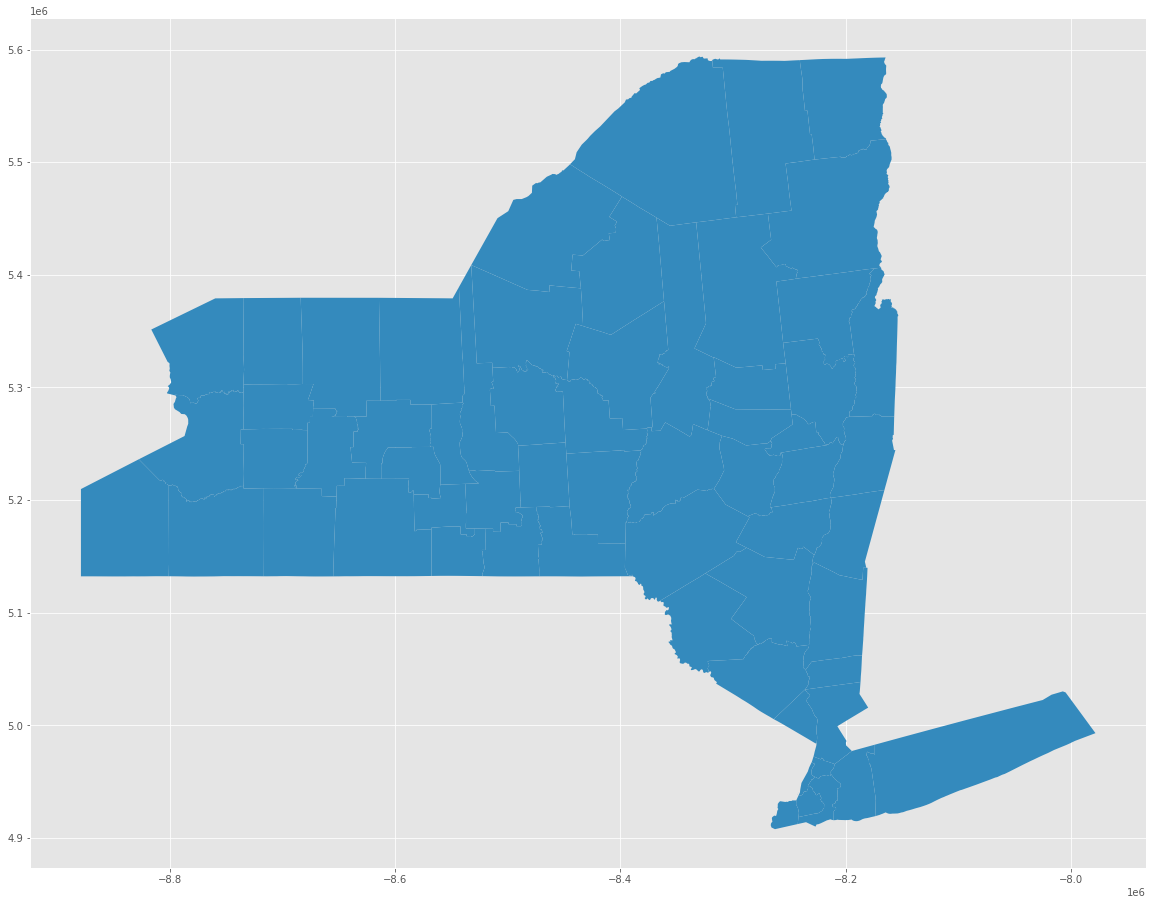

In [12]:
projected_NY_Counties.plot()

Our colours look a bit plain and boring.  Let's upgrade our plot to something more informative.

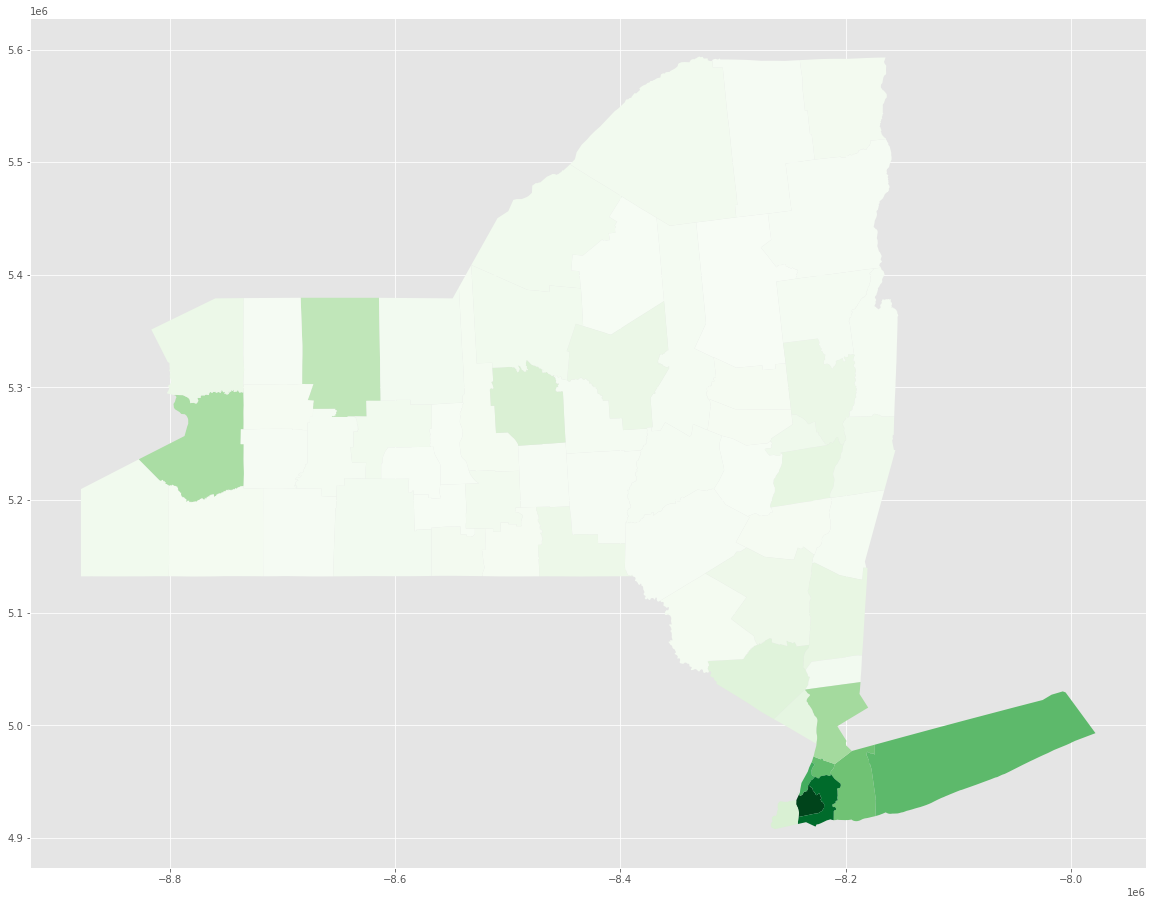

In [13]:
projected_NY_Counties.plot(column = 'POP2020', cmap='Greens')

Have a play around with mapping differnt coloums using different colours and different colouring schemes

`Scheme must be in the set: ['quantiles', 'fisher_jenks', 'equal_interval']`

If you want to play with the colour schemes for the map then take a look here.
https://matplotlib.org/examples/color/colormaps_reference.html

`Possible values are: Accent, Accent_r, Blues, Blues_r, BrBG, BrBG_r, BuGn, BuGn_r, BuPu, BuPu_r, CMRmap, CMRmap_r, Dark2, Dark2_r, GnBu, GnBu_r, Greens, Greens_r, Greys, Greys_r, OrRd, OrRd_r, Oranges, Oranges_r, PRGn, PRGn_r, Paired, Paired_r, Pastel1, Pastel1_r, Pastel2, Pastel2_r, PiYG, PiYG_r, PuBu, PuBuGn, PuBuGn_r, PuBu_r, PuOr, PuOr_r, PuRd, PuRd_r, Purples, Purples_r, RdBu, RdBu_r, RdGy, RdGy_r, RdPu, RdPu_r, RdYlBu, RdYlBu_r, RdYlGn, RdYlGn_r, Reds, Reds_r, Set1, Set1_r, Set2, Set2_r, Set3, Set3_r, Spectral, Spectral_r, Wistia, Wistia_r, YlGn, YlGnBu, YlGnBu_r, YlGn_r, YlOrBr, YlOrBr_r, YlOrRd, YlOrRd_r, afmhot, afmhot_r, autumn, autumn_r, binary, binary_r, bone, bone_r, brg, brg_r, bwr, bwr_r, cool, cool_r, coolwarm, coolwarm_r, copper, copper_r, cubehelix, cubehelix_r, flag, flag_r, gist_earth, gist_earth_r, gist_gray, gist_gray_r, gist_heat, gist_heat_r, gist_ncar, gist_ncar_r, gist_rainbow, gist_rainbow_r, gist_stern, gist_stern_r, gist_yarg, gist_yarg_r, gnuplot, gnuplot2, gnuplot2_r, gnuplot_r, gray, gray_r, hot, hot_r, hsv, hsv_r, inferno, inferno_r, jet, jet_r, magma, magma_r, nipy_spectral, nipy_spectral_r, ocean, ocean_r, pink, pink_r, plasma, plasma_r, prism, prism_r, rainbow, rainbow_r, seismic, seismic_r, spectral, spectral_r, spring, spring_r, summer, summer_r, terrain, terrain_r, viridis, viridis_r, winter, winter_r`

We can also control the alpha of the map as well if we want to.

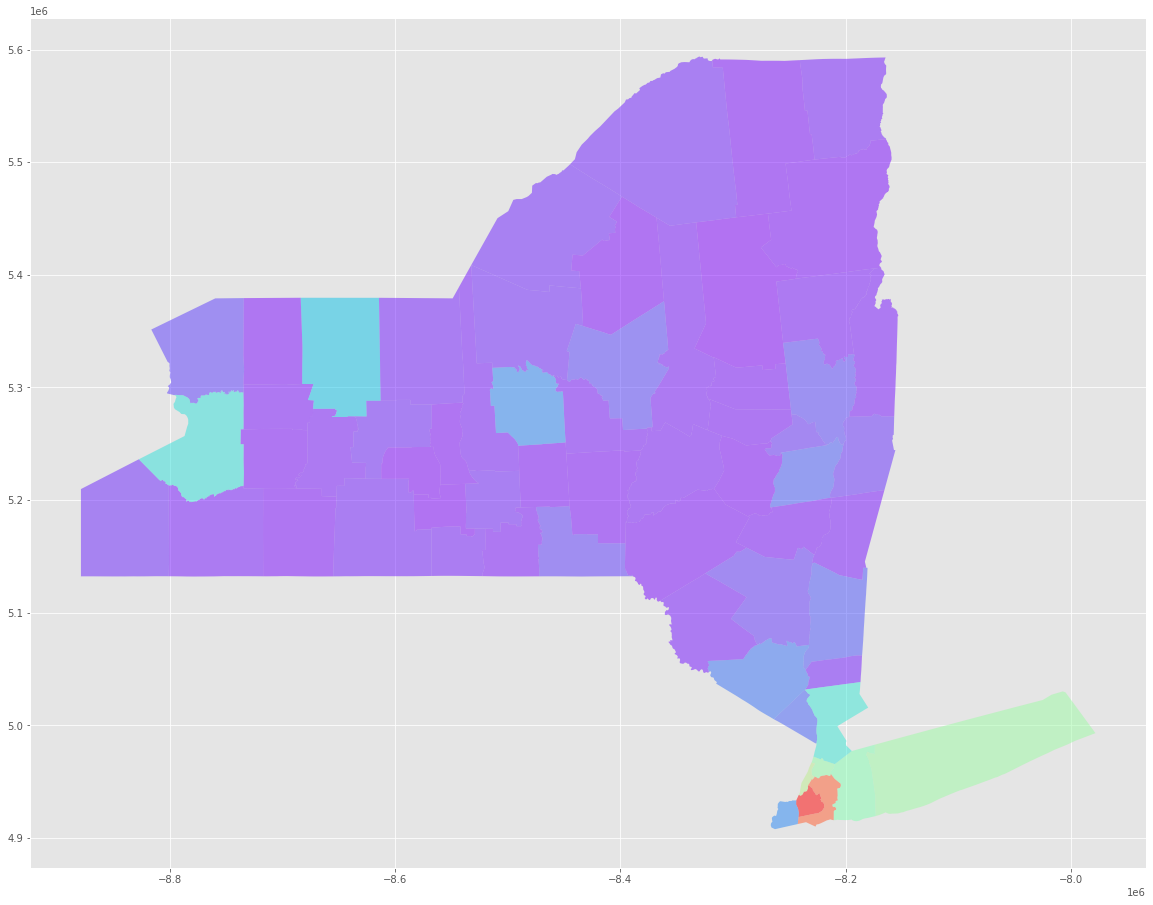

In [14]:
projected_NY_Counties.plot(column='POP2020', cmap='rainbow', alpha = 0.5)

## Warding off evil 

The electoral wards of London represent voting areas for local councils; let's now compare their populations to see where the population densities are in the city. 

Population data is available from the ONS - they link the population of different ages to a 'Ward Code', which is a standard identified of that ward: http://www.ons.gov.uk/ons/publications/re-reference-tables.html?edition=tcm%3A77-301951

Let's read it into a standard Pandas dataframe:

In [15]:
data_path = "./data/wk9/2011persons.csv"

persons = pd.read_csv(data_path, encoding = 'latin1')
persons.head()

,Ward Code 1,Ward Name 1,Local Authority,All Ages,0-4,5-9,10-14,15-19,20-24,25-29,30-34,35-39,40-44,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85-89,90plus
0,E05000001,Aldersgate,City of London,"1,472",50,36,23,19,66,138,151,114,112,113,109,131,135,73,65,62,48.0,19.0,8.0
1,E05000005,Bishopsgate,City of London,226,2,1,2,6,20,64,38,33,11,13,12,13,8,2,0,0,1.0,0.0,0.0
2,E05000015,Cripplegate,City of London,"2,786",108,66,54,102,117,233,250,238,268,237,212,183,187,163,125,76,93.0,43.0,31.0
3,E05000017,Farringdon Within,City of London,278,8,12,26,9,31,40,34,24,24,17,12,14,13,10,3,1,0.0,0.0,0.0
4,E05000018,Farringdon Without,City of London,"1,112",17,5,6,6,146,233,164,90,83,106,51,59,67,31,22,11,8.0,5.0,2.0


We need to make sure the data is in the right format - to remove commas and dashes, as we have done before. I'm just going to clean up the "All Ages" column for this example, but you could apply this to any (or all) numerical columns.

In [16]:
persons.replace(',', '', regex=True, inplace=True)
persons['All Ages'] = persons['All Ages'].replace('-', 'NaN', regex=True).astype('float')
persons['All Ages'].head()

0    1472.0
1     226.0
2    2786.0
3     278.0
4    1112.0
Name: All Ages, dtype: float64

## Exercise 
Using the Ward Code, **merge** the *persons* geodataframe with the *londonWards* dataframe to create a new geodataframe called "geopeople". You can do do this in pretty much exactly the same way you've done for merging 'vanilla' dataframes - refer to the examples from earlier in the term if your syntax is rusty. 

In [17]:
import pandas
projected_NY_Counties['NAME'] = projected_NY_Counties['NAME'].apply(lambda s: s.upper() if type(s) == str else s)
AP_differences = pandas.read_csv('./drive/MyDrive/Johann/UCL/Second Year/Quantitative Methods 2/FinalProject/AP_differences.csv')
projected_NY_Counties

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,ALBANY,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((-8205062.308 5250430.387, -8204688.8..."
1,ALLEGANY,ALLE,974100,36003,020000,West,50470,49927,48946,46456,None,None,N,1035.209131,2019-04-26,210499.339279,2.681179e+09,"POLYGON ((-8715445.059 5210517.511, -8715255.4..."
2,BRONX,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,None,None,Y,57.472148,2019-10-04,57253.861278,1.488522e+08,"POLYGON ((-8222688.769 4969941.853, -8222391.5..."
3,BROOME,BROO,974102,36007,030000,Central,212160,200536,200600,198683,None,None,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((-8445160.095 5194600.839, -8445118.2..."
4,CATTARAUGUS,CATT,974103,36009,040000,West,84234,83955,80317,77042,None,None,N,1324.309219,2019-04-26,276084.505560,3.429945e+09,"POLYGON ((-8796630.804 5213021.819, -8796395.7..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,WASHINGTON,WASH,974155,36115,530000,East,59330,61042,63216,61302,None,None,N,845.855708,2017-11-10,302358.996697,2.190756e+09,"POLYGON ((-8168309.994 5404951.953, -8168279.3..."
58,WAYNE,WAYN,974156,36117,540000,Central,89123,93765,93772,91283,None,None,N,1395.598959,2018-02-08,254972.219986,3.614585e+09,"POLYGON ((-8543432.584 5388979.904, -8540669.3..."
59,WESTCHESTER,WEST,974157,36119,550000,East,874866,923459,949113,1004457,None,None,N,499.972897,2019-10-04,182997.677827,1.294924e+09,"POLYGON ((-8187320.894 5031318.973, -8187347.4..."
60,WYOMING,WYOM,974158,36121,560000,West,42507,43424,42155,40531,None,None,N,596.822633,2018-09-20,176096.925232,1.545764e+09,"POLYGON ((-8723558.961 5262953.491, -8723548.8..."


In [18]:

geopeople = projected_NY_Counties.merge(AP_differences, left_on = 'NAME', right_on = 'County', how = 'inner')
geopeople.head()

,NAME,ABBREV,GNIS_ID,FIPS_CODE,SWIS,NYSP_ZONE,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,NYC,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry,Unnamed: 0,County,Difference
0,ALBANY,ALBA,974099,36001,010000,East,292594,294565,304204,314848,None,None,N,532.791779,2017-11-10,166077.834242,1.379924e+09,"POLYGON ((-8205062.308 5250430.387, -8204688.8...",22486,ALBANY,-0.173248
1,ALLEGANY,ALLE,974100,36003,020000,West,50470,49927,48946,46456,None,None,N,1035.209131,2019-04-26,210499.339279,2.681179e+09,"POLYGON ((-8715445.059 5210517.511, -8715255.4...",23264,ALLEGANY,1.185714
2,BRONX,BRON,974101,36005,600000,Long Island,1203789,1332650,1385108,1472654,None,None,Y,57.472148,2019-10-04,57253.861278,1.488522e+08,"POLYGON ((-8222688.769 4969941.853, -8222391.5...",37922,BRONX,-0.110705
3,BROOME,BROO,974102,36007,030000,Central,212160,200536,200600,198683,None,None,N,715.287465,2019-04-26,227933.332021,1.852586e+09,"POLYGON ((-8445160.095 5194600.839, -8445118.2...",23328,BROOME,-0.183166
4,CATTARAUGUS,CATT,974103,36009,040000,West,84234,83955,80317,77042,None,None,N,1324.309219,2019-04-26,276084.505560,3.429945e+09,"POLYGON ((-8796630.804 5213021.819, -8796395.7...",24227,CATTARAUGUS,-0.019983


**One important caveat**: to plot the map, you need to be invoking *.plot()* on a **geo**dataframe - so you need to merge **on** the geodataframe, with the dataframe as the argument. You can check this with the *type(geopeople)* command:

In [19]:
type(geopeople)

geopandas.geodataframe.GeoDataFrame

Compare to merging **on** persons, which will give you a "pandas.core.frame.DataFrame" object - *not* a geodataframe.

Let's now calculate the population *density* using the 'HECTARES' column:

## Portable data

At this point, we'll save the data into a .csv so it's easy to use in other software. This will be useful.

In [20]:
data_path = "./data/wk9/borough_density.csv"

geopeople.to_csv(data_path)

And let's project this into a new geodataframe:

In [21]:
original_crs = geopeople.crs
target_crs = {'datum':'NAD83', 'no_defs':True, 'proj':'merc'}
projected_geopeople = geopeople.to_crs(crs=target_crs)

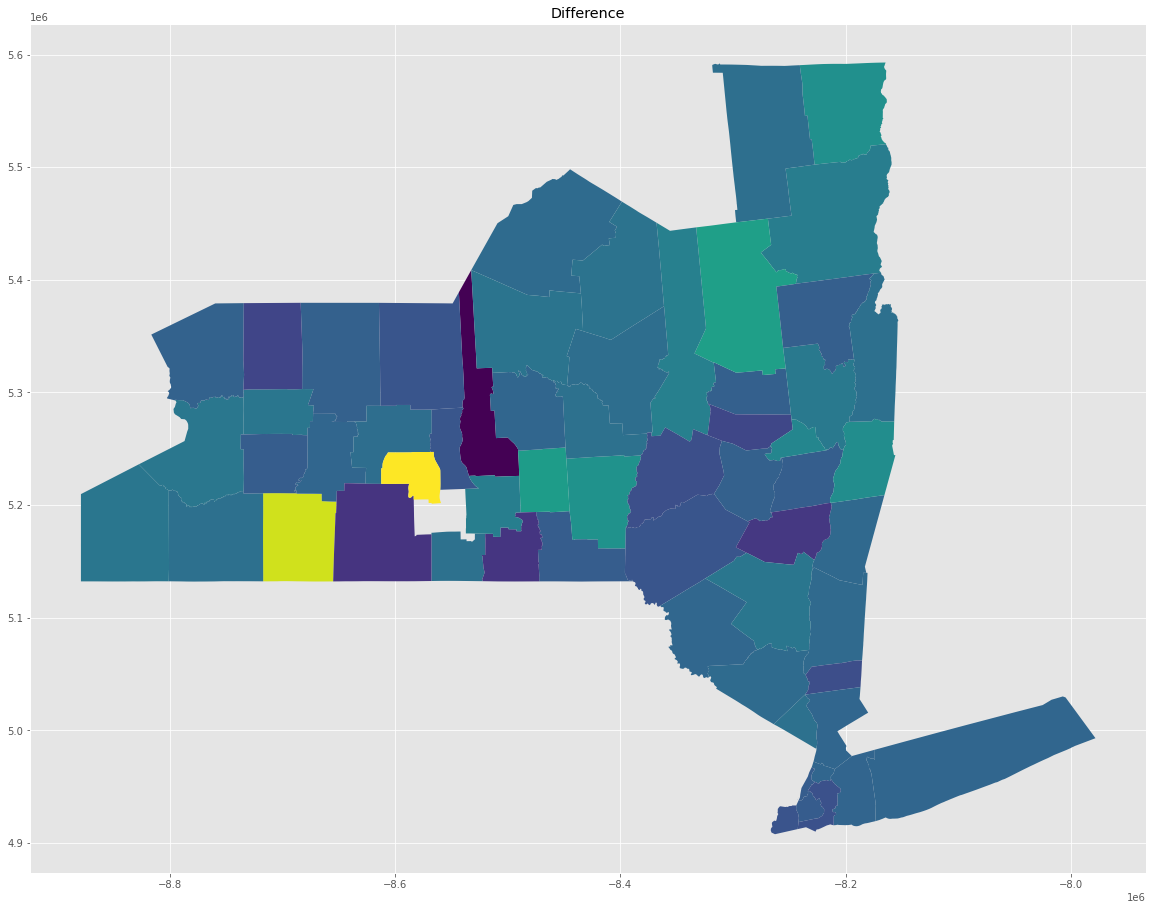

In [22]:
projected_geopeople.plot(column='Difference')
plt.title('Difference')
plt.savefig('./data/wk9/Wards.png')

## Exercise
Create a choropleth map of the population of each ward using *projected_geopeople.plot()* and save it as an image file. Use the optional arguments: 

1. *column*, To specific the 'All Ages' column in the dataset to colour the map based on population, and
2. *colormap*, using the 'Blues' colormap to specify a white-blue colour range

(It looks as if there aren't population estimates for the smaller City of London Wards, so we're missing them - if we wanted to show them, we would need a different dataset)

## Between the Bars

We have a nice map, but no colour scale to explain what the colours mean; unfortunately, this is a place where geopandas falls down and we have to do something intensely complex. The code you'll see below was created by the inimitable Stephan Hugel to fill in the gaps (more for the superkeen here: sensitivecities.com/so-youd-like-to-make-a-map-using-python-EN.html#.VlSfMcq2-K7)


In [23]:
import numpy as np
import matplotlib

In [24]:

# Convenience functions for working with colour ramps and bars
def colorbar_index(ncolors, cmap, labels=None, **kwargs):
    """
    This is a convenience function to stop you making off-by-one errors
    Takes a standard colour ramp, and discretizes it,
    then draws a colour bar with correctly aligned labels
    """
    cmap = cmap_discretize(cmap, ncolors)
    mappable = plt.cm.ScalarMappable(cmap=cmap)
    mappable.set_array([])
    mappable.set_clim(-0.5, ncolors+0.5)
    colorbar = matplotlib.pyplot.colorbar(mappable, **kwargs)
    colorbar.set_ticks(np.linspace(0, ncolors, ncolors))
    colorbar.set_ticklabels(range(ncolors))
    if labels:
        colorbar.set_ticklabels(labels)
    return colorbar

def cmap_discretize(cmap, N):
    """
    Return a discrete colormap from the continuous colormap cmap.

        cmap: colormap instance, eg. cm.jet. 
        N: number of colors.

    Example
        x = resize(arange(100), (5,100))
        djet = cmap_discretize(cm.jet, 5)
        imshow(x, cmap=djet)

    """
    if type(cmap) == str:
        cmap = get_cmap(cmap)
    colors_i = np.concatenate((np.linspace(0, 1., N), (0., 0., 0., 0.)))
    colors_rgba = cmap(colors_i)
    indices = np.linspace(0, 1., N + 1)
    cdict = {}
    for ki, key in enumerate(('red', 'green', 'blue')):
        cdict[key] = [(indices[i], colors_rgba[i - 1, ki], colors_rgba[i, ki]) for i in range(N+1)]
    return matplotlib.colors.LinearSegmentedColormap(cmap.name + "_%d" % N, cdict, 1024)

In [25]:
from pysal.viz.mapclassify import Quantiles

## Them's the breaks
There are various ways to split the data, the default of which is quantiles - to order the data and then split the N data values we have evenly into q chunks, each of which has N/q data points. Consider the median - this splits the dataset into two chunks of size N/2; quartiles split the data into four chunks of size N/4; *quantiles* split the data into q chunks with N/q points. We will specify 5 chunks using the k=5 argument.

(The documentation is here, if you're interested in finding out more: https://github.com/pysal/pysal/blob/master/pysal/contrib/viz/mapping.py)

In [26]:
breaks = Quantiles(
    geopeople['Difference'].values,
    k=5)
print(breaks)

               Quantiles                
 
Lower            Upper             Count
         x[i] <= -0.232               12
-0.232 < x[i] <= -0.113               12
-0.113 < x[i] <= -0.037               12
-0.037 < x[i] <=  0.045               12
 0.045 < x[i] <=  1.339               12


In [27]:
print(breaks.bins)

[-0.2315139  -0.11329301 -0.03659827  0.04542902  1.33928571]


We'll create a set of labels; again, this is a bit beyond what we've done before so don't worry if it appears a bit mysterious.

In [28]:
bar_labels = ['<=%.3f'% b for b in breaks.bins]
print(bar_labels)

['<=-0.232', '<=-0.113', '<=-0.037', '<=0.045', '<=1.339']


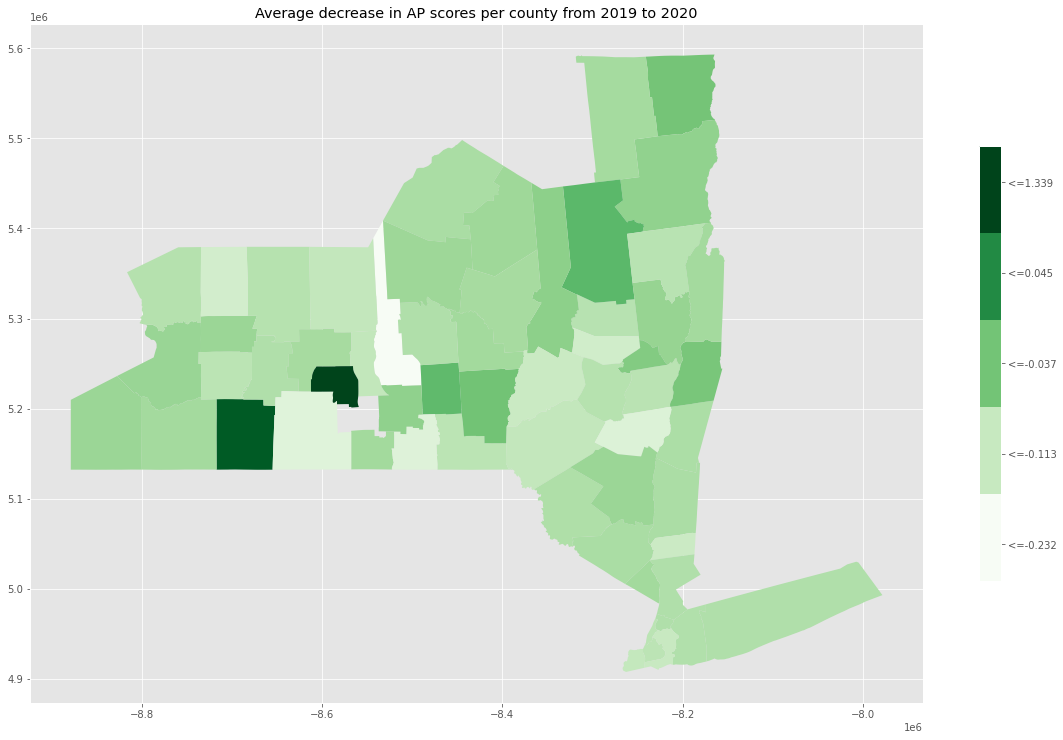

In [38]:
projected_geopeople.plot(column='Difference', cmap='Greens', k=5)
plt.title('Average decrease in AP scores per county from 2019 to 2020')

cmap = plt.get_cmap('Greens')
colorbar_index(ncolors=5, cmap=cmap, shrink=0.5, labels=bar_labels)
plt.savefig('AP_Changes.png')
#Yates (-1.339 points) and Allegany (-1.185) stand out. The next one on the list is Hamilton county; with a negative change of 0.4 points. No data for Schuyler county. 

## Working with Point Data and Choropleths
Let's now go back to our twitter data and plot it on the same axes...

In [30]:
data_path = "./data/wk9/tweet_data.csv"

tweets = pd.read_csv(data_path, parse_dates = [1], infer_datetime_format = True, encoding = 'latin1')
tweets.head()

,id,dateT,name,Lat,Lon,OSGB_Lon,OSGB_Lat
0,15,2010-04-28 15:03:00,MrFlexDot (Felix Tekyi),51.682488,-0.045406,535225.835914,200000.009703
1,19,2010-04-28 15:03:00,genyfrmdablck (geny ),51.539869,-0.135413,529408.436064,183977.283107
2,26,2010-04-28 15:03:00,makapala (Dave Woodford),51.459499,-0.036607,536499.925360,175219.249296
3,31,2010-04-28 15:03:00,JayVades (JayVades),51.518075,0.024400,540557.757933,181848.336146
4,38,2010-04-28 15:03:00,CatchAChoo (Jimmy Choo),51.510000,-0.217000,523831.617422,180514.655542


We will convert these points to a geometry object - previously, the geometry column stored data associated with the polygons for the wards - we'll build geometries representing points and then convert the dataframe to a geodataframe. Again, the code below is a bit opaque - it's a recipe for creating these geometries.

In [31]:
from shapely.geometry import Point
tweets['geometry'] = tweets.apply(lambda x: Point(x['Lon'], x['Lat']), axis=1)

## Project points into the same basis
In the next steps, we will 1) convert the dataframe to a geodataframe. 2) sets the CRS (co-ordinate reference system, remember) to the original CRS that we got from the wards data, and 3) projects into the same projection (using mercator, as before)

In [32]:
geotweets = gp.GeoDataFrame(tweets)
geotweets.crs = original_crs
geotweets.to_crs(crs=target_crs, inplace=True)

In [33]:
geotweets.head()

,id,dateT,name,Lat,Lon,OSGB_Lon,OSGB_Lat,geometry
0,15,2010-04-28 15:03:00,MrFlexDot (Felix Tekyi),51.682488,-0.045406,535225.835914,200000.009703,POINT (-0.045 51.682)
1,19,2010-04-28 15:03:00,genyfrmdablck (geny ),51.539869,-0.135413,529408.436064,183977.283107,POINT (-0.135 51.540)
2,26,2010-04-28 15:03:00,makapala (Dave Woodford),51.459499,-0.036607,536499.925360,175219.249296,POINT (-0.037 51.459)
3,31,2010-04-28 15:03:00,JayVades (JayVades),51.518075,0.024400,540557.757933,181848.336146,POINT (0.024 51.518)
4,38,2010-04-28 15:03:00,CatchAChoo (Jimmy Choo),51.510000,-0.217000,523831.617422,180514.655542,POINT (-0.217 51.510)


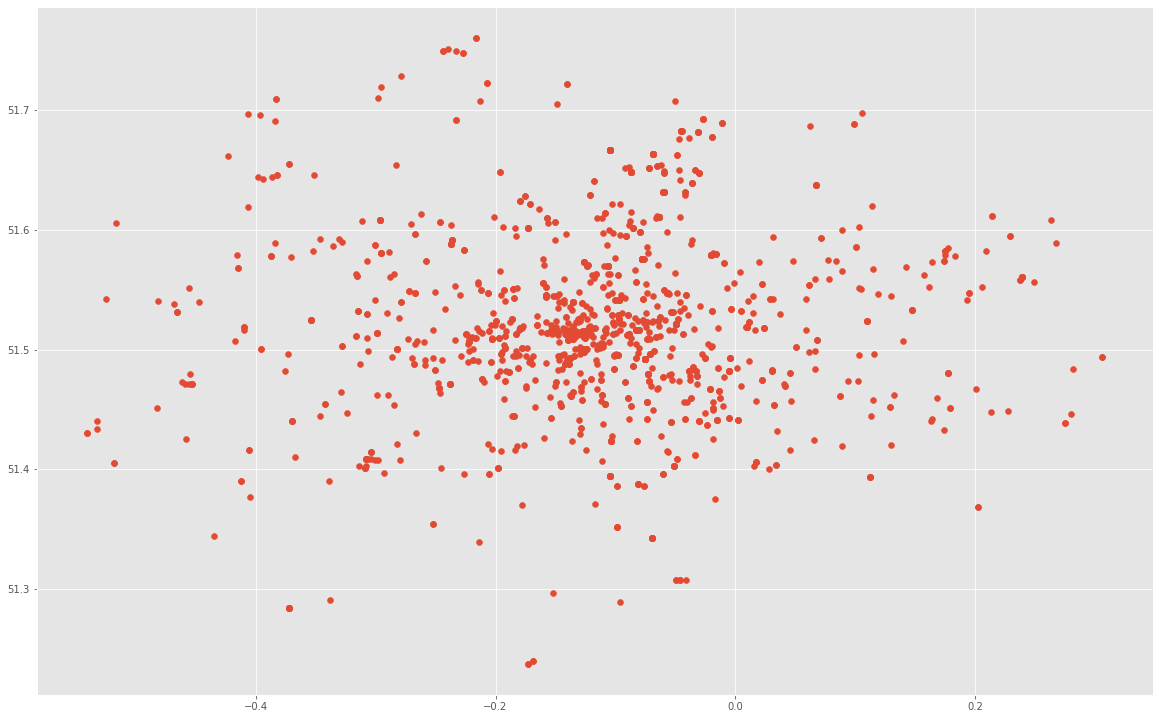

In [34]:
geotweets.plot()

KeyError: ignored

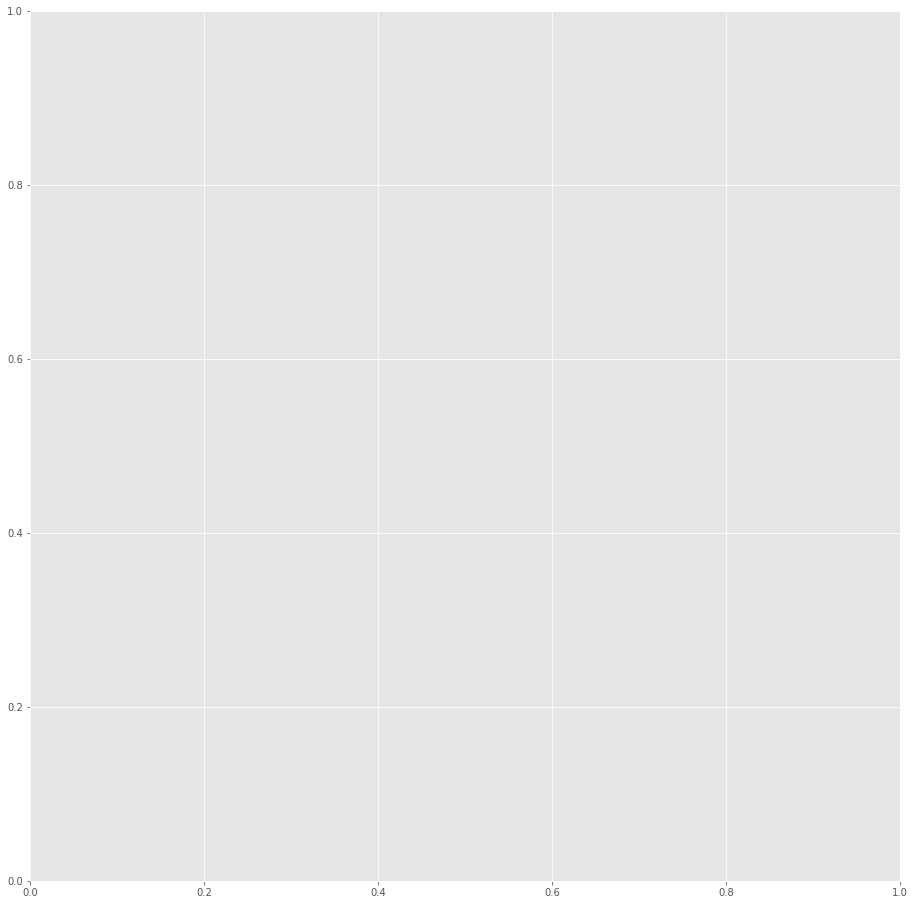

In [35]:
ax = projected_geopeople.plot(column='density', cmap='Greens', scheme='quantiles', k=5)
plt.title('2011 population by Ward')

cmap = plt.get_cmap('Greens')
colorbar_index(ncolors=5, cmap=cmap, shrink=0.5, labels=bar_labels)

geotweets.plot(ax=ax)

## Extension:
We can make these points a bit bigger by using a 'buffer' - this creates a geometry of circles rather than points:

In [ ]:
geotweets['points'] = geotweets['geometry']
geotweets['geometry'] = gp.GeoSeries(tweets['points']).buffer(200)
geotweets.head()

And we'll add in a dummy variable we can use to make them all the same colour. Again, a bit clunky but means when we put them on a colormap (the object which converts a value to a color), it will give the same colour for each circle.

In [ ]:
geotweets['dummy']=1

Now we can plot this in the same projection, putting geopeople (which has the borough boundaries) on the same axes as the point twitter data.

In [ ]:
ax = projected_geopeople.plot(column='density', cmap='Greens', scheme='quantiles', k=5)
plt.title('2011 population by Ward')

cmap = plt.get_cmap('Greens')
colorbar_index(ncolors=5, cmap=cmap, shrink=0.5, labels=bar_labels)

geotweets.plot(column='dummy', cmap='RdBu', ax=ax)

This has been a bit fiddly, but we have a tweet map with a choropleth of underlying residential population densities. You could look at evening-time tweets only and then we're starting to get somewhere. But this is just an example, so you can now use this as a recipe for your own maps. Or...

## Alternatives to Python

It's worth experimenting with alternatives if you intend to create more complex maps. For example, **Carto** is an option for producing choropleths. Here is a brief tutorial of how to map population density based on the csv we created (*borough_density.csv*) that has the unprojected borough polygons and their associated population densities. It's still sensible to do data linking and processing here in python, as it makes the final stages fairly straightforward - note that Carto works with latlon (unprojected) data rather than the projected/OSGB data.

In [ ]:
from IPython.display import YouTubeVideo
YouTubeVideo("fofRRwZjiyg")